In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import TranscriptionDataset, collate_fn
from Model.encoder_net import EncoderNet
from Model.decoder_net import DecoderNet
from train import train_transcriber, pre_train_encoder
print(torch.__version__)
from tqdm import tqdm_notebook as tqdm


/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.4.0


In [2]:
# torch.backends.cudnn.enabled = False

### 1. We now Train the Encoder-Decoder Model
> * First we pre-train the encoder on a binary classification task. 
> * Good performance on this task is a good indicator that the encoder is modelling the distribution of the underlying data properly -- This is crucial for the correct functioning of 
our system

#### a) Pre-Trin Encoder
---

In [5]:
def pre_train_encoder_network():
    '''
    We pretrain the encoder to solve be able to classify an image as either
    Ingridients or Nutrition_Facts. An encoder that is able to do this is a good starting
    point for the transcription task.
    '''
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy'
    debug = not torch.cuda.is_available()
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=45, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=45, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    config = {
        'keep_prob': 0.995
    }
    learning_rate = 0.5e-3
    
    encoder = EncoderNet(config_params=config)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, encoder.parameters()), 
        lr=learning_rate, weight_decay=0.005
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [5, 10, 20, 30, 40, 50, 100, 150], gamma=0.5
    )
    return pre_train_encoder(
        encoder, optimizer, train_loader, dev_loader, scheduler=scheduler,
        epochs=5, restore=True, save=False
    )

In [6]:
# losses, accuracies = pre_train_encoder_network()

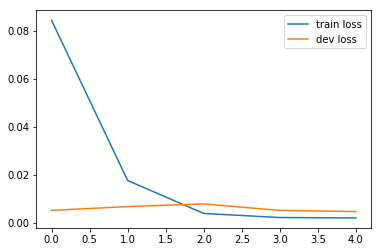

In [6]:
plt.plot(losses[0], label='train loss'); plt.plot(losses[1], label='dev loss')
plt.legend()

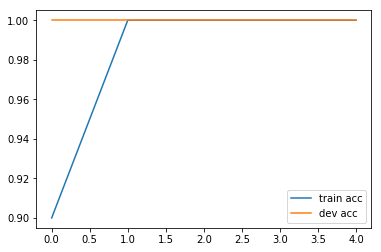

In [7]:
plt.plot(accuracies[0], label='train acc'); plt.plot(accuracies[1], label='dev acc')
plt.legend()

#### b) Train Full E-D model
---

In [2]:
def train_localizer_network(learning_rate=None):
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy' 
    debug = not torch.cuda.is_available()
    
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=40, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=40, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    
    
    config = {
        'keep_prob': 0.9995
    }
    if not learning_rate: learning_rate = 1.5e-3
    
    encoder = EncoderNet(config_params=config)
    word_vectors = train_dataset.get_word_vectors()
    embed_size = len(word_vectors[0])
    output_size = train_dataset.get_output_size()
    decoder = DecoderNet(word_vectors, output_size, embed_size)
    
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, parameters), 
        lr=learning_rate, weight_decay=0
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [50, 70], gamma=0.5
    )
    results = train_transcriber(
        encoder, decoder, optimizer, train_loader, dev_loader,
        train_dataset, dev_dataset, epochs=50, scheduler=None,
        restore=False, save=True
    )
    return results

In [4]:
lrs = [1e-4, 5e-4, 9e-4,]
results = {}
for lr in lrs:
    c_results  = train_localizer_network(learning_rate=lr)
    results[str(lr)] = c_results  

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  5.986876964569092
	 Dev Loss =  6.0909552574157715
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.935330390930176
	 Dev Loss =  5.38953161239624
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.376282691955566
	 Dev Loss =  5.157308101654053
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.096141338348389
	 Dev Loss =  5.006310939788818
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00097458746


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.8501384258270264
	 Dev Loss =  4.921623229980469
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.6363489627838135
	 Dev Loss =  4.8961615562438965
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.4447174072265625
	 Dev Loss =  4.952710151672363
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.301290512084961
	 Dev Loss =  5.088244915008545
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.1998941898345947
	 Dev Loss =  5.238261699676514
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.126896619796753
	 Dev Loss =  5.375133991241455
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.590173244476318
	 Dev Loss =  5.062111854553223
	 Train BLEU =  0.0016390543
	 Dev BLEU =  0.0016390543


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.51829195022583
	 Dev Loss =  5.00911808013916
	 Train BLEU =  0.0016390543
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.0886123180389404
	 Dev Loss =  6.03033447265625
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.005519151687622
	 Dev Loss =  6.12349271774292
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.9338293075561523
	 Dev Loss =  6.604465961456299
	 Train BLEU =  0.0017941146
	 Dev BLEU =  0.0017165844


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.838155508041382
	 Dev Loss =  6.6411333084106445
	 Train BLEU =  0.008163356
	 Dev BLEU =  0.009945463


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.745424509048462
	 Dev Loss =  6.759212493896484
	 Train BLEU =  0.007849983
	 Dev BLEU =  0.009117166


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.6504032611846924
	 Dev Loss =  6.9120612144470215
	 Train BLEU =  0.0017941146
	 Dev BLEU =  0.0017941146


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.5604372024536133
	 Dev Loss =  7.093997001647949
	 Train BLEU =  0.006375745
	 Dev BLEU =  0.007370445


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.481119155883789
	 Dev Loss =  7.2529520988464355
	 Train BLEU =  0.0055417996
	 Dev BLEU =  0.0065508625


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  4.042433261871338
	 Dev Loss =  5.133236408233643
	 Train BLEU =  0.00097458746
	 Dev BLEU =  0.0010785584


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.145596981048584
	 Dev Loss =  6.537840366363525
	 Train BLEU =  0.00081952714
	 Dev BLEU =  0.0


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  3.01029896736145
	 Dev Loss =  9.884441375732422
	 Train BLEU =  0.0016390543
	 Dev BLEU =  0.0012292907


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.9137141704559326
	 Dev Loss =  14.257248878479004
	 Train BLEU =  0.0017941146
	 Dev BLEU =  0.00081952714


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.7660346031188965
	 Dev Loss =  9.659725189208984
	 Train BLEU =  0.010399748
	 Dev BLEU =  0.0144013455


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.639941930770874
	 Dev Loss =  7.453526973724365
	 Train BLEU =  0.0017941146
	 Dev BLEU =  0.0019491749


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.5331239700317383
	 Dev Loss =  7.670583248138428
	 Train BLEU =  0.004464768
	 Dev BLEU =  0.0030634692


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.462761640548706
	 Dev Loss =  7.912360191345215
	 Train BLEU =  0.0019491749
	 Dev BLEU =  0.0019491749


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.3980870246887207
	 Dev Loss =  8.107370376586914
	 Train BLEU =  0.0019491749
	 Dev BLEU =  0.0019491749


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.3594536781311035
	 Dev Loss =  8.25241756439209
	 Train BLEU =  0.005479144
	 Dev BLEU =  0.004498995


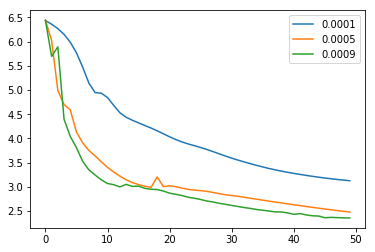

In [5]:
for k, v in results.items():
    plt.plot(v[0], label=k)
plt.legend()

In [3]:
r = train_localizer_network(learning_rate=9e-4)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  2.8170480728149414
	 Dev Loss =  4.390874720634298
	 Train BLEU =  0.0068183304
	 Dev BLEU =  0.0012994499


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  1.0424103736877441
	 Dev Loss =  2.5693924731396613
	 Train BLEU =  0.01317358
	 Dev BLEU =  0.02013612


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.7376818656921387
	 Dev Loss =  2.4584432079436933
	 Train BLEU =  0.007622926
	 Dev BLEU =  0.014958836


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.5470394492149353
	 Dev Loss =  2.593627303204638
	 Train BLEU =  0.005788542
	 Dev BLEU =  0.010890829


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.4891499876976013
	 Dev Loss =  2.562144969372039
	 Train BLEU =  0.006757837
	 Dev BLEU =  0.017767088


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.4917740821838379
	 Dev Loss =  3.0078307504349566
	 Train BLEU =  0.0050067413
	 Dev BLEU =  0.003403886


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.40910717844963074
	 Dev Loss =  3.037397308552519
	 Train BLEU =  0.013321994
	 Dev BLEU =  0.01679863


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.382828950881958
	 Dev Loss =  4.7706586401513285
	 Train BLEU =  0.006092406
	 Dev BLEU =  0.009373228


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.3195343315601349
	 Dev Loss =  2.8352799491679415
	 Train BLEU =  0.0048709023
	 Dev BLEU =  0.0061264983


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))


==== Performance Check === 
	 Train Loss =  0.26291319727897644
	 Dev Loss =  3.00327745650677
	 Train BLEU =  0.0054353354
	 Dev BLEU =  0.006411461


In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

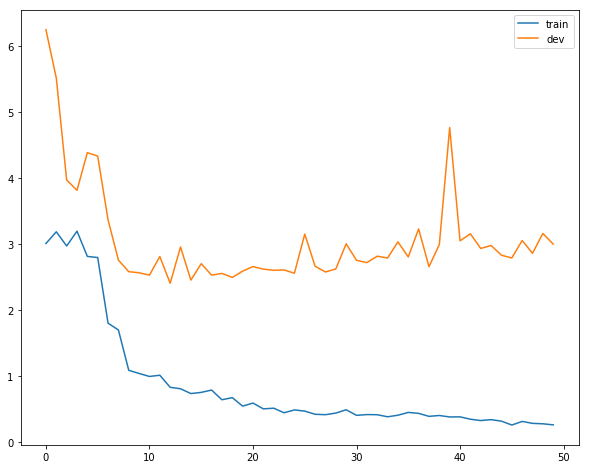

In [7]:
train_losses, dev_losses, train_bleu, dev_bleu = r
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
import numpy as np
np.save('results', r)
plt.legend()

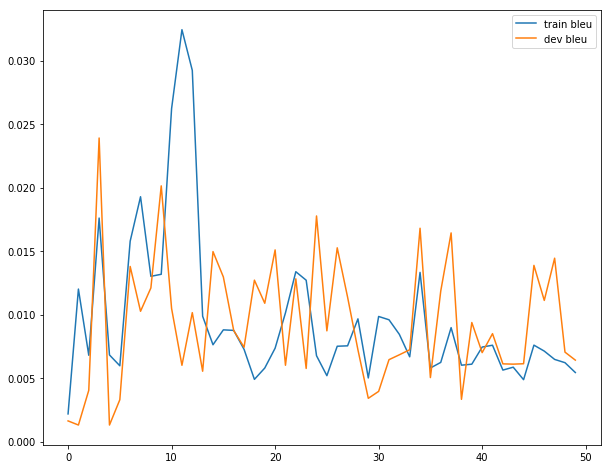

In [6]:
plt.plot(train_bleu, label='train bleu')
plt.plot(dev_bleu, label='dev bleu')
plt.legend()

In [ ]:
def ensure_all_data_is_available():
    import numpy as np
    data_path = '../Data/FullData/train_dev_test.npy'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    annotations = np.load(ANNOTATION_PATH).item()
    images = (
            np.load(data_path).item()['train'] + np.load(data_path).item()['dev'] + 
            np.load(data_path).item()['test']
    )
    bad = []
    for img in tqdm(images):
        num = img[:img.rfind('_')]
        nut = '1_' + num; ingr = '0_'+num
        if nut not in annotations or ingr not in annotations:
            bad.append(num)
    print(set(bad))